uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 32

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 676
text 01 captcha shape (32, 100) noise 0.5317091456182311
text 70 captcha shape (32, 100) noise 0.3916747982250164
text 04 captcha shape (32, 100) noise 0.851765483126142
text 67 captcha shape (32, 100) noise 0.2977274117772327
text 60 captcha shape (32, 100) noise 0.8082621257270096
text 82 captcha shape (32, 100) noise 0.6677921309562015
text 40 captcha shape (32, 100) noise 0.8255491121415252
text 86 captcha shape (32, 100) noise 0.5783670890135378
text 65 captcha shape (32, 100) noise 0.3588539766854798
text 18 captcha shape (32, 100) noise 0.28867005207225027
text 94 captcha shape (32, 100) noise 0.12294211033564126
number of samples in group 656
text 718 captcha shape (32, 100) noise 0.050219258631867665
text 078 captcha shape (32, 100) noise 0.8567344501002044
text 371 captcha shape (32, 100) noise 0.06467416735045343
text 671 captcha shape (32, 100) noise 0.7880504633172919
text 313 captcha shape (32, 100) noise 0

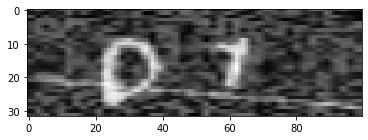

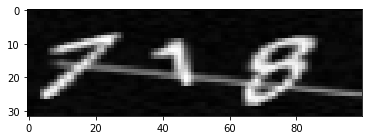

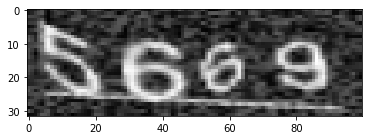

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, hid, noise_batch):
        
        BATCH_SIZE = img_embedded.shape[0]

        img = torch.cat((img_embedded, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [12]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [13]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [14]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [15]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_char_accuracies
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

In [16]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain)) # with noise
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=128, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        
        input_dim_dict = {
            "img" : captchaHeight * captchaWidth,
        }
        var_dim_dict = {
            "num_char" : 1,
            "noise" : 1,
        }
        
        dependency_dict = {
            "num_char" : ["img"],
            "noise" : ["img"],
        }
        
        to_event_dict = {
            "num_char" : 0,
            "noise" : 1,
        }
        
        dist_type_dict = {
            "num_char" : ("cate", len(self.num_char_domain)),
            "noise" : "norm"
        }
        
        self.gmade_n = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
           dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=1)
        
        self.noise_dim = 128
        
        input_dim_dict = {
            "img_embedded" : 1280,
        }
        
        var_dim_dict = {
            "char" : 1, 
        }
        
        dependency_dict = {
            "char" : ["img_embedded"]
        }
        
        to_event_dict = {
            "char" : 0
        }
        
        dist_type_dict = {
           "char" : ("cate", len(self.char_dict))
        }
        
        self.gmade_char = GMADE(input_dim_dict, dependency_dict, var_dim_dict, 
           dist_type_dict, to_event_dict, use_cuda=use_cuda, hidden_layers=3, hidden_sizes=3)
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    def guide_gmade_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            
            input_dict = {
                "img" : img_raw
            }
            out_1 = self.gmade_n(input_dict, suffix="")
            N_index = out_1["num_char"]
            N_index = torch.add(N_index, self.num_char_domain[0])
            noise_batch = out_1["noise"]
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, None)
            noise_batch = noise_batch.repeat(1, self.noise_dim)
            rnn_input = torch.cat()
            
            def _rec(i, h):
                if i < MAX_N:
                    i_input = torch.tensor(i)
                    if USE_CUDA:
                        i_input = i_input.cuda()
                    i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                    i_input = i_input.repeat(BS, 1)
                    sample_mask = i < N_index
                    input_dict_char = {
                        "img_embedded" : input_emb,
                    }
                    out_2 = self.gmade_char(input_dict_char, suffix="_"+str(i), mask_dict={"char" : sample_mask})
                    c_i = out_2["char"]
                    c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                    _rec(i + 1, h)
            _rec(0, None)
    
    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    sample_mask = i < N_index
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                    sampled_c.append((sample_mask, c_i))
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_images = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        if sampled_c[j][0][i]:
                            chars += self.char_dict[sampled_c[j][1][i]]
                            return _get_chars(j + 1, chars, i)
                    return chars
                if i < BS:
                    chars = ""
                    chars = _get_chars(0, "", i)
                    #print("chars", chars)
                    rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                    rendered_images.append(rendered_image)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
                
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide_gmade_rec, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_noise_in_charnet_gmade_400_noise_128_rec.json")


all_dependencies num_char ['img']
all_dependencies noise ['img']
all_sets [(0,)]
input_ordering [0]
out_sets [(0,), (0,)]
out_orderings [0, 0]
hid_orderings size 3200
num hid layers: 3
expanded_input_ordering size 3200
expanded_output_ordering size 5
number of levels: 1
input_levels [['img']]
out_levels [['num_char', 'noise']]
all_dependencies char ['img_embedded']
all_sets [(0,)]
input_ordering [0]
out_sets [(0,)]
out_orderings [0]
hid_orderings size 3840
num hid layers: 3
expanded_input_ordering size 1280
expanded_output_ordering size 10
number of levels: 1
input_levels [['img_embedded']]
out_levels [['char']]
Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 7.136386923551561; Epoch takes 129 seconds
loss at epoch 2 is 5.936099377393724; Epoch takes 127 seconds
loss at epoch 3 is 5.339044213771819; Epoch takes 127 seconds
loss at epoch 4 is 4.993703140735627; Epoch takes 127 seconds
loss at epoch 5 is 4.620672351956366; Epoch takes 127 seconds
use_train = True AVG Noise Difference: 0.11044831753530476 Total correct: 89 accuracy:89/2000= 0.0445 char_accuracy:1542/5992= 0.25734312416555405
use_train = False AVG Noise Difference: 0.10318014010420895 Total correct: 30 accuracy:30/1000= 0.03 char_accuracy:699/2991= 0.2337011033099298
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.319 | Actual Noise: 0.391 | Predicted Text: 90 | Actual Text: 98 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.369 | Actual Noise: 0.373 | Predicted Text: 7605 | Actual Text: 2067 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.676 | Actual Noise: 0.785 | Predicted Text: 37 | Actual Text: 46 | Correct: 0
N_predicted

loss at epoch 22 is 2.8277779880166056; Epoch takes 127 seconds
loss at epoch 23 is 2.758283671289682; Epoch takes 127 seconds
loss at epoch 24 is 2.888226365566256; Epoch takes 127 seconds
loss at epoch 25 is 2.6617206065952757; Epoch takes 127 seconds
use_train = True AVG Noise Difference: 0.04959827611788717 Total correct: 204 accuracy:204/2000= 0.102 char_accuracy:2148/5992= 0.35847797062750336
use_train = False AVG Noise Difference: 0.047376879809236376 Total correct: 91 accuracy:91/1000= 0.091 char_accuracy:1080/3008= 0.35904255319148937
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.298 | Actual Noise: 0.313 | Predicted Text: 844 | Actual Text: 048 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.559 | Actual Noise: 0.536 | Predicted Text: 6505 | Actual Text: 4655 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.371 | Actual Noise: 0.376 | Predicted Text: 21 | Actual Text: 29 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.72 | Actua

loss at epoch 43 is 2.196020226716995; Epoch takes 127 seconds
loss at epoch 44 is 2.1191545687392357; Epoch takes 127 seconds
loss at epoch 45 is 2.1771881543230265; Epoch takes 127 seconds
use_train = True AVG Noise Difference: 0.039375879276914785 Total correct: 227 accuracy:227/2000= 0.1135 char_accuracy:2215/5992= 0.3696595460614152
use_train = False AVG Noise Difference: 0.03922824672148737 Total correct: 100 accuracy:100/1000= 0.1 char_accuracy:1106/3005= 0.36805324459234606
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.713 | Actual Noise: 0.691 | Predicted Text: 9889 | Actual Text: 8919 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.861 | Actual Noise: 0.916 | Predicted Text: 606 | Actual Text: 602 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.199 | Actual Noise: 0.132 | Predicted Text: 0005 | Actual Text: 7500 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.746 | Actual Noise: 0.779 | Predicted Text: 887 | Actual Text: 798 | 

loss at epoch 63 is 2.0128323795301846; Epoch takes 127 seconds
loss at epoch 64 is 2.0037132088243967; Epoch takes 127 seconds
loss at epoch 65 is 2.033441957354545; Epoch takes 127 seconds
use_train = True AVG Noise Difference: 0.03388374893794216 Total correct: 234 accuracy:234/2000= 0.117 char_accuracy:2264/5992= 0.37783711615487314
use_train = False AVG Noise Difference: 0.03284953303961174 Total correct: 121 accuracy:121/1000= 0.121 char_accuracy:1102/2971= 0.3709188825311343
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.848 | Actual Noise: 0.882 | Predicted Text: 751 | Actual Text: 579 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.219 | Actual Noise: 0.172 | Predicted Text: 272 | Actual Text: 722 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.298 | Actual Noise: 0.278 | Predicted Text: 5757 | Actual Text: 5719 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.174 | Actual Noise: 0.078 | Predicted Text: 11 | Actual Text: 11 | Corr

loss at epoch 83 is 1.9211161451861265; Epoch takes 171 seconds
loss at epoch 84 is 1.99418916625157; Epoch takes 176 seconds
loss at epoch 85 is 1.916747657984495; Epoch takes 173 seconds
use_train = True AVG Noise Difference: 0.035254285752197904 Total correct: 247 accuracy:247/2000= 0.1235 char_accuracy:2303/5992= 0.38434579439252337
use_train = False AVG Noise Difference: 0.034932540952897995 Total correct: 126 accuracy:126/1000= 0.126 char_accuracy:1178/2975= 0.39596638655462185
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.286 | Actual Noise: 0.295 | Predicted Text: 555 | Actual Text: 415 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.36 | Actual Noise: 0.336 | Predicted Text: 3630 | Actual Text: 3600 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.904 | Actual Noise: 0.941 | Predicted Text: 9772 | Actual Text: 2973 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.454 | Actual Noise: 0.462 | Predicted Text: 88 | Actual Text: 78 | C

KeyboardInterrupt: 

In [17]:
save_metric_to_disk("captcha_metrics_noise_in_charnet_gmade_100_rec_mean_field.json")

Logs